In [2]:
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder


In [3]:
# Only Training data is used

df_FaultFree = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_FaultFree_Training.RData')['fault_free_training']
df_Faulty = pyreadr.read_r(r'F:\TEP_Data\The TEP Dataset\TEP_Faulty_Training.RData')['faulty_training']

In [4]:
DF = pd.concat([df_FaultFree,df_Faulty]) # Join both fault free and faulty dataset
DF.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


# Scale the dataset

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()

sc.fit(df_FaultFree.iloc[:,3:])


StandardScaler()

# Select a subset of the Entire Dataset

In [6]:
# Select a subset of the data from simulation runs 1 to 10, and filter out fault numbers 9 and 15
reduced_data = DF.loc[(DF['simulationRun'] >= 1) & (DF['simulationRun'] <= 10)]
reduced_data = reduced_data[reduced_data['faultNumber'] != 9]
reduced_data = reduced_data[reduced_data['faultNumber'] != 15]

# Apply scaling transformation to selected features of the filtered dataset
X = sc.transform(reduced_data[reduced_data['sample'] > 20].iloc[:, 3:])
# Add a random number coloumn to X as a control feature
control_col = np.random.random(len(X)).reshape(-1,1)
X_mod = np.hstack((X,control_col ))

# Extract the fault numbers that occur after the 20th sample
Y = reduced_data[reduced_data['sample'] > 20]['faultNumber'].values

In [7]:
le = LabelEncoder()
Y_enc = le.fit_transform(Y)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_mod, Y_enc, test_size=0.2, random_state=42)

In [9]:
y_train.shape

(72960,)

In [10]:
x_train.shape

(72960, 53)

In [11]:

# assuming y_test is a numpy array and contains class labels as integers
class_counts = np.bincount(y_test[::10])
print("Number of samples from each class:", class_counts)

Number of samples from each class: [ 81  77  99  91  88  87 108  94 114  99  79 106  93 101 105 103  97 108
  94]


# Train the XG Boosting Tree

In [12]:
import xgboost as xgb

xg = xgb.XGBClassifier(random_state=0)

xg.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [13]:
xg.score(x_train, y_train)

0.9722450657894737

In [14]:
xg.score(x_test,y_test)

0.8644188596491228

In [15]:
feature_name = np.array(reduced_data.columns[3:])
feature_name = np.append(feature_name,"control_feature")

X_test = pd.DataFrame(data=x_test,columns=feature_name)

# Import the libraries contaning SHAPLY values

In [16]:
import shap
shap.initjs()

In [38]:
# explain the model's predictions using SHAP
# explainer = shap.KernelExplainer(xg.predict_proba, x_train[::50])

idx_sample = 56
shap_values = explainer.shap_values(X_test.iloc[idx_sample,:])

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [39]:
shap_values[0].shape

(53,)

In [40]:
sampled_test_data = X_test.iloc[idx_sample]
sampled_test_labels = y_test[idx_sample]

print(f"the predicted class is: {xg.predict([sampled_test_data])}")
cls_index =  sampled_test_labels
print(f"the Actual class is: {cls_index}")

for fault_cls in range(0,19):
    print(f"Force plot for fault class: {fault_cls}")
    display(shap.force_plot(explainer.expected_value[fault_cls], shap_values[fault_cls],sampled_test_data ))

the predicted class is: [3]
the Actual class is: 3
Force plot for fault class: 0


Force plot for fault class: 1


Force plot for fault class: 2


Force plot for fault class: 3


Force plot for fault class: 4


Force plot for fault class: 5


Force plot for fault class: 6


Force plot for fault class: 7


Force plot for fault class: 8


Force plot for fault class: 9


Force plot for fault class: 10


Force plot for fault class: 11


Force plot for fault class: 12


Force plot for fault class: 13


Force plot for fault class: 14


Force plot for fault class: 15


Force plot for fault class: 16


Force plot for fault class: 17


Force plot for fault class: 18


# Tree Explainer for Faster Explanation

In [18]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(xg)


shap_values = explainer.shap_values(X_test.iloc[::50])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
X_test.iloc[::50]

In [19]:
# Visualize the SHAP values for a single example
sampled_test_data = X_test.iloc[::50]
sampled_test_labels = y_test[::50]

sample_idx = 45

print(f"the predicted class is: {xg.predict(sampled_test_data.iloc[[sample_idx]])}")
cls_index =  sampled_test_labels[sample_idx]
print(f"the Actual class is: {cls_index}")

for fault_cls in range(0,19):
    print(f"Force plot for fault class: {fault_cls}")
    display(shap.force_plot(explainer.expected_value[fault_cls], shap_values[fault_cls][sample_idx],sampled_test_data.iloc[sample_idx] ))

the predicted class is: [10]
the Actual class is: 10
Force plot for fault class: 0


Force plot for fault class: 1


Force plot for fault class: 2


Force plot for fault class: 3


Force plot for fault class: 4


Force plot for fault class: 5


Force plot for fault class: 6


Force plot for fault class: 7


Force plot for fault class: 8


Force plot for fault class: 9


Force plot for fault class: 10


Force plot for fault class: 11


Force plot for fault class: 12


Force plot for fault class: 13


Force plot for fault class: 14


Force plot for fault class: 15


Force plot for fault class: 16


Force plot for fault class: 17


Force plot for fault class: 18


# Real time Feature Importance for Prediction

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Ignoring `palette` because no `hue` variable has been assigned.


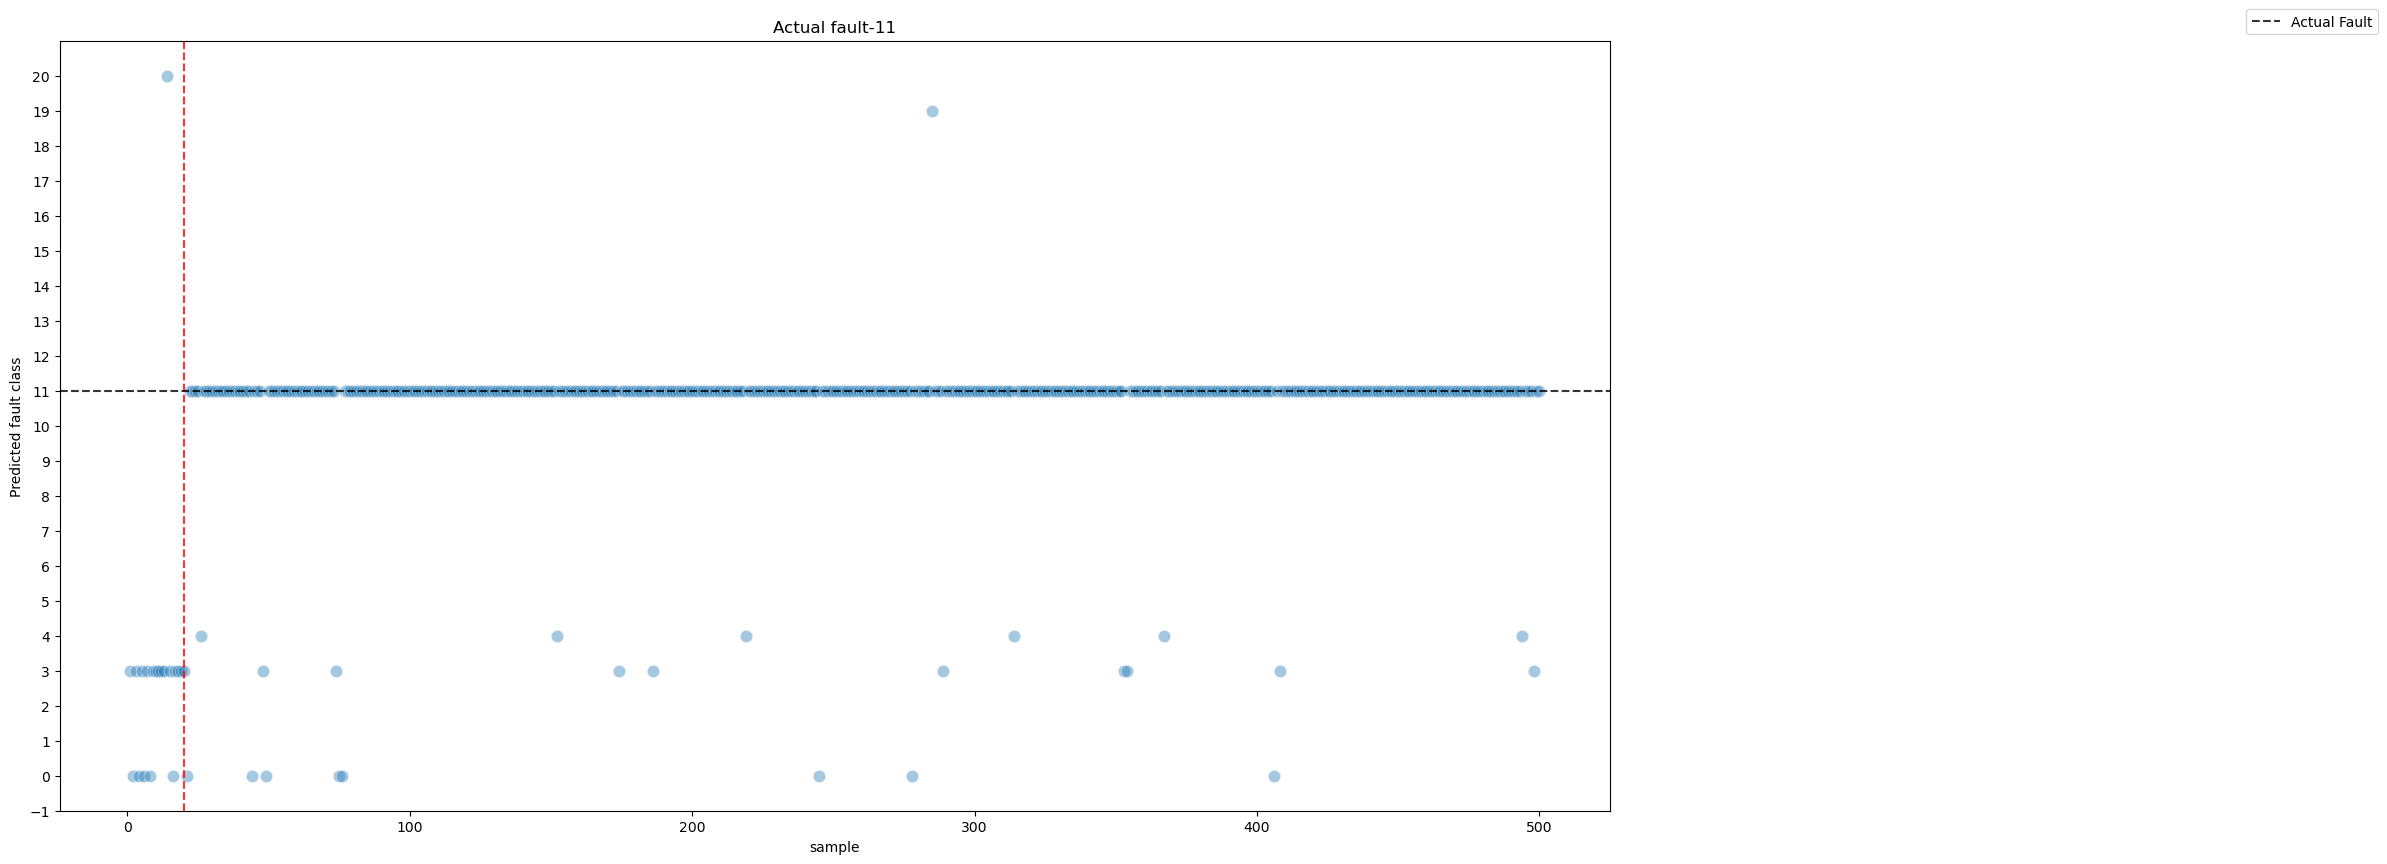

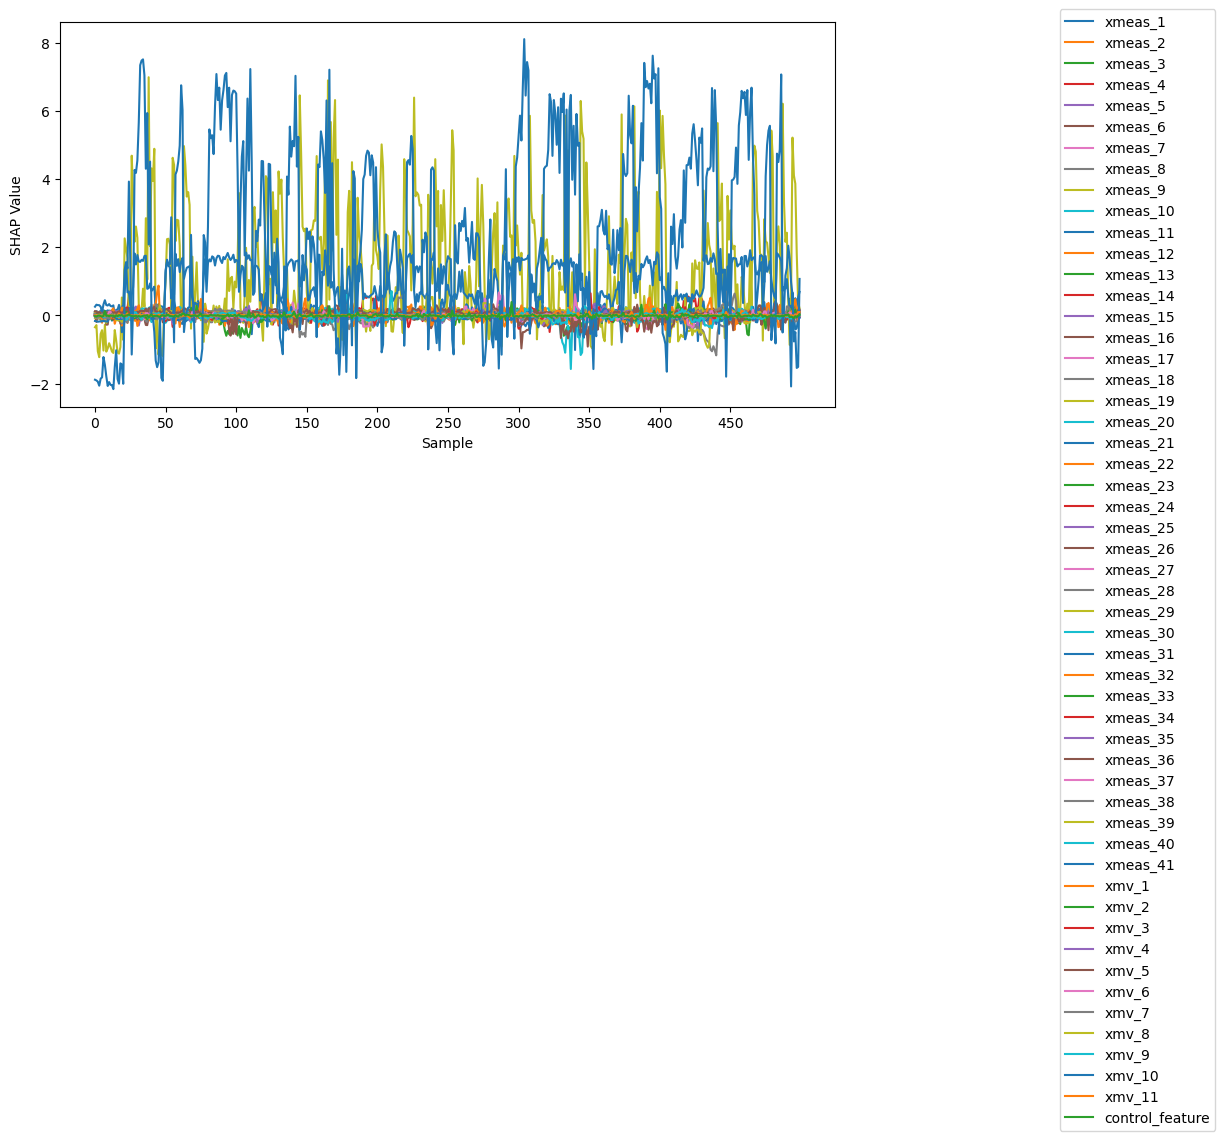

In [20]:
F_num=11

df_new= DF[(DF['faultNumber']==F_num) & (DF['simulationRun']==2)].copy()
x_new = df_new.iloc[:,3:]
x_new = sc.transform(x_new)

# Generate random numbers and append to x_new
rand_nums = np.random.rand(len(x_new), 1)
x_new = np.hstack((x_new, rand_nums))

# generate shapely values
shap_values_sample = explainer.shap_values(x_new)


y_pred = xg.predict(x_new)
# shap values for this fault class
data = shap_values_sample[le.transform([F_num])[0]]

y_pred = le.inverse_transform(y_pred)


f, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(x=df_new['sample'],y=y_pred,palette="coolwarm",s=80,alpha=0.4)

plt.axvline(20,c='r',alpha=0.8,linestyle ='--')
plt.axhline(F_num,c='black',alpha=0.8,label='Actual Fault',linestyle ='--')
plt.legend(bbox_to_anchor=(1.5, 1.05))
plt.ylabel('Predicted fault class')
plt.title(f'Actual fault-{F_num}')
plt.yticks(np.arange(-1,21,1))
plt.show()

# generate some sample data


# create a figure and axis object
fig, ax = plt.subplots(figsize=(10,5))

# loop over the columns and plot each one
for i in range(data.shape[1]):
    ax.plot(data[:, i], label=f'{sampled_test_data.columns[i]}')

# set the x-axis label and tick positions
ax.set_xlabel('Sample')
ax.set_xticks(np.arange(0, data.shape[0], 50))

# set the y-axis label
ax.set_ylabel('SHAP Value')

# add a legend
ax.legend(bbox_to_anchor=(1.5, 1.05))

# show the plot
plt.show()

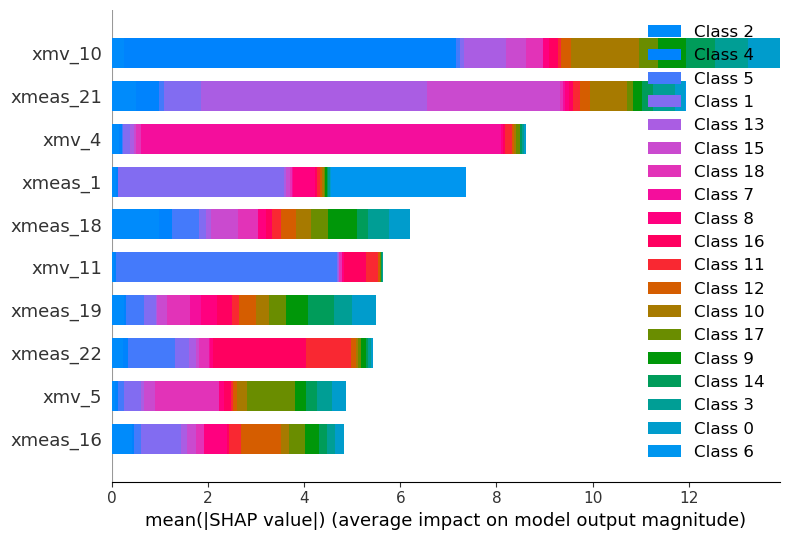

In [23]:
shap.summary_plot(shap_values,feature_names=X_test.columns, max_display=10)